In [2]:
import gymnasium as gym
import minigrid
import torch
import torch.nn as nn
import numpy as np
from torchvision.transforms import ToTensor
import cv2
from torch.utils.data import TensorDataset,Dataset
from torchvision import datasets
from tqdm import tqdm

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


Create a `Dataset` class to create a custom dataset from the saved np arrays (Data retrived from the *data.ipynb* file)
- Reduces computational load
- Allows dataloader to load data into memory one by one reducing memory usage
- Check for shape compatibility with the model requirements (B, C, H, W)

In [4]:
class GenieDataset(Dataset):
    def __init__(self, images_path, actions_path, next_frame_path):
        self.images = np.load(images_path, mmap_mode="r")
        self.actions = np.load(actions_path, mmap_mode="r")
        self.next_frame = np.load(next_frame_path, mmap_mode="r")
        
        print(f"Dataset - Images shape: {self.images.shape}")
        print(f"Dataset - Actions shape: {self.actions.shape}")
        print(f"Dataset - Next frames shape: {self.next_frame.shape}")
    
    def __len__(self):
        return len(self.actions)
    
    def __getitem__(self, index):
        image = self.images[index]
        action = self.actions[index]
        next_frame = self.next_frame[index]
        
        image = torch.tensor(image, dtype=torch.float32).to(device)
        next_frame = torch.tensor(next_frame, dtype=torch.float32).to(device)
        action = torch.tensor(action, dtype=torch.long).to(device)
        
        if len(image.shape) == 3 and image.shape[-1] == 3:
            image = image.permute(2, 0, 1)
            next_frame = next_frame.permute(2, 0, 1)
        
        if image.max() > 1.0:
            image = image / 255.0
            next_frame = next_frame / 255.0
        
        return image, action, next_frame

In [8]:
full_dataset = GenieDataset("../data/images.npy","../data/actions.npy","../data/next_frames.npy")

Dataset - Images shape: (95370, 3, 64, 64)
Dataset - Actions shape: (95370,)
Dataset - Next frames shape: (95370, 3, 64, 64)


Split data into training and testing dataset with `random_split()`

In [5]:
from torch.utils.data import random_split
dataset_size = len(full_dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

train_dataset, test_dataset = random_split(full_dataset,[train_size,test_size])

Create a training `DataLoader`

In [6]:
from torch.utils.data import DataLoader
trainDataloader = DataLoader(train_dataset,batch_size=32,shuffle=True)

`ImageEncoder(nn.Module)` is the first step of the model architecture
It acts as a Image Encoder that converts *64 x 64* images into a latent vector of size 512 and 16 tokens 
- Input : Image with 3 color channels
- Output : Vector of size (16,512) 
- 16 tokens because the transformer learns token embeddings

In [ ]:
class ImageEncoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3,out_channels=64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
        )
        self.flat  = nn.Flatten(start_dim=2)
        self.embed = nn.Linear(512*4*4,512)
    
    def forward(self,img):
        conv_out = self.conv(img)
        flatten = self.flat(conv_out)
        flatten = flatten.permute(0, 2, 1)
        return flatten
        

`class ActionEmbedding(nn.Module)`  handles the action input. Since the model's actions (like 'Turn Left', 'Move Forward') are discrete vlaues, they need to be converted into a numerical format that the transformer can use.

- It uses an nn.Embedding layer to transform each integer action (0 through 6) into a dense vector (embedding) of dimension 512.

- This embedding acts as a token that represents the action, which is then concatenated with the image tokens.

In [8]:
class ActionEmbedding(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.embedding = nn.Embedding(7,512)
    
    def forward(self,a):
        return self.embedding(a).unsqueeze(1)

The `Transformer` class is the core of the model's temporal reasoning. It considers the relationship between the initial state of the environment (from the ImageEncoder) and the action taken (from the ActionEmbedding) to predict the outcome.

- The image tokens from the `ImageEncoder` and action tokens from the `ActionEmbedding` are concatinated and fed to the transformer as input.

- Positional Embeddings are added to the input sequence to give the model information about the order of the tokens (i.e., which are image features and which is the action).

- It then passes this sequence through a `TransformerEncoderLayer`, which uses self-attention mechanisms to weigh the importance of different tokens and model how the action will affect the visual features.

- The output is a new sequence of tokens where the information from the action has been integrated with the image features.

In [9]:
class Transformer(nn.Module):
    def __init__(self,embed_dim=512, n_heads=8, num_layers=1, seq_len=17):
        super().__init__()
        
        self.pos_embedding = nn.Parameter(torch.randn(1,seq_len,embed_dim))
        
        self.transformer_encoder = nn.TransformerEncoderLayer(d_model=embed_dim,nhead=n_heads,dim_feedforward=2048,dropout=0.1,activation='relu')
        
        self.transformer  = nn.TransformerEncoder(self.transformer_encoder,num_layers=num_layers)
    
    def forward(self,x):
        x = x + self.pos_embedding[:, :x.size(1), :]  
        x = x.permute(1, 0, 2)  
        out = self.transformer(x)
        out = out.permute(1, 0, 2)  
        return out

The `FrameDecoder` class does the opposite of the `ImageEncoder`. It takes the output spatial tokens from the Transformer and reconstructs the predicted next image frame.

- It reshapes the sequence of tokens back into a spatial format (4x4 with 512 channels).

- It then uses a series of `ConvTranspose2d` layers (also known as deconvolutional layers) to progressively upsample this data, effectively "drawing" the pixels of the predicted next frame.

- A final Sigmoid activation function ensures the output pixel values are in a valid range [0, 1].

In [10]:
class FrameDecoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64,3,kernel_size=4,stride=2,padding=1),
            nn.Sigmoid()
        )
    def forward(self,x):
        b = x.shape[0]
        x = x.permute(0, 2, 1)
        x = torch.reshape(x,(b,512,4,4))
        return self.decoder(x)

The `MiniGenie` class is the main model that ties everything together. It orchestrates the entire process from input to output.

Forward Pass:

- The initial_frame is passed to the ImageEncoder to get spatial tokens.

- The actions are passed to the ActionEmbedding to get action tokens.

- These two sets of tokens are concatenated into a single sequence.

- This sequence is fed into the Transformer to get the contextually aware output tokens.

- The output tokens corresponding to the spatial features are passed to the FrameDecoder.

- The FrameDecoder generates the final output_image, which is the model's prediction of the next frame.

In [11]:
class MiniGenie(nn.Module):
    def __init__(self, embed_dim=512, n_heads=8, num_layers=1, seq_len=17) -> None:
        super().__init__()
        self.encoder = ImageEncoder()
        self.action_embedding = ActionEmbedding()
        self.transformer = Transformer(embed_dim, n_heads, num_layers, seq_len)
        self.decoder = FrameDecoder()
    
    def forward(self,initial_frame,actions):
        encoded_image = self.encoder(initial_frame)
        encoded_action = self.action_embedding(actions)
        concatinated_input = torch.cat((encoded_image,encoded_action),dim=1)
        temporal_out = self.transformer(concatinated_input)
        spatial_tokens = temporal_out[:, :-1, :]
        output_image = self.decoder(spatial_tokens)
        return output_image

Training loop of the model - 
- Saves the model when the current loss is better than the best loss
- `tqdm` to show training progress 

In [12]:
def train(model,dataloader,optimizer,loss_fn,epochs=10,save_path='mini-genie'):
    model.train()
    best_loss = np.inf
    for epoch in range(epochs):
        epoch_loss = 0.0
        with tqdm(dataloader,unit="batch") as tepoch:
            for initial_frames, actions, final_frames in tepoch:
                final_frame = model(initial_frames,actions)
                optimizer.zero_grad()
                loss = loss_fn(final_frame,final_frames)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
                tepoch.set_postfix(loss=loss.item())
        avg_loss = epoch_loss / len(dataloader)
        print(f"Epoch: {epoch} | Loss: {avg_loss}")
        if avg_loss < best_loss:
            best_loss = avg_loss
            torch.save(model.state_dict(), save_path)
            print(f"Model saved at epoch {epoch+1} with loss {best_loss}")

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)
model = MiniGenie(embed_dim=512,n_heads=8,num_layers=1,seq_len=17).to(device)
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.0001)

Model training - 

In [15]:
train(model=model,dataloader=trainDataloader,optimizer=optimizer,loss_fn=loss_fn,epochs=10,save_path="mini-genie.pth")

100%|██████████| 2385/2385 [03:39<00:00, 10.88batch/s, loss=0.00602]


Epoch: 0 | Loss: 0.014089920170081923
Model saved at epoch 1 with loss 0.014089920170081923


100%|██████████| 2385/2385 [03:01<00:00, 13.12batch/s, loss=0.00574]


Epoch: 1 | Loss: 0.004897713052026881
Model saved at epoch 2 with loss 0.004897713052026881


100%|██████████| 2385/2385 [02:47<00:00, 14.20batch/s, loss=0.00851]


Epoch: 2 | Loss: 0.0040445002688161355
Model saved at epoch 3 with loss 0.0040445002688161355


100%|██████████| 2385/2385 [02:53<00:00, 13.72batch/s, loss=0.00348]


Epoch: 3 | Loss: 0.003637612015457992
Model saved at epoch 4 with loss 0.003637612015457992


100%|██████████| 2385/2385 [02:48<00:00, 14.16batch/s, loss=0.00361]


Epoch: 4 | Loss: 0.0034126604782257317
Model saved at epoch 5 with loss 0.0034126604782257317


100%|██████████| 2385/2385 [02:48<00:00, 14.14batch/s, loss=0.00406]


Epoch: 5 | Loss: 0.0032610143137513903
Model saved at epoch 6 with loss 0.0032610143137513903


100%|██████████| 2385/2385 [02:47<00:00, 14.24batch/s, loss=0.00604]


Epoch: 6 | Loss: 0.003093805366275789
Model saved at epoch 7 with loss 0.003093805366275789


100%|██████████| 2385/2385 [02:53<00:00, 13.79batch/s, loss=0.00267]


Epoch: 7 | Loss: 0.002947373235153046
Model saved at epoch 8 with loss 0.002947373235153046


100%|██████████| 2385/2385 [02:46<00:00, 14.30batch/s, loss=0.00299]


Epoch: 8 | Loss: 0.0027277241078297173
Model saved at epoch 9 with loss 0.0027277241078297173


100%|██████████| 2385/2385 [02:42<00:00, 14.67batch/s, loss=0.00267]


Epoch: 9 | Loss: 0.002472697532847055
Model saved at epoch 10 with loss 0.002472697532847055


Testing the model on the testing dataset
- Avg. training loss - 0.0022417666847619477

In [16]:
test_model = MiniGenie(embed_dim=512,n_heads=8,num_layers=1,seq_len=17).to(device)
testDataloader = DataLoader(test_dataset,batch_size=32,shuffle=True)
test_model.load_state_dict(torch.load("mini-genie.pth"))
test_model.eval()
with torch.inference_mode():
    total_loss = 0.0
    with tqdm(testDataloader,unit="batch") as tpoch:
        for initial_frame,action,next_frame in (tpoch):
            model_result = test_model(initial_frame,action)
            loss = loss_fn(model_result,next_frame)
            total_loss+= loss.item()
    final_test_loss = total_loss/len(testDataloader)
    print(f"Testing loss is: {final_test_loss}")
        


c:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
100%|██████████| 597/597 [00:28<00:00, 20.70batch/s]

Testing loss is: 0.0022417666847619477


Model evaluation - 
Evaluation Metrics 
- Mean Squared Error (MSE): 0.000447
- Mean Absolute Error (MAE): 0.001996
- Peak Signal-to-Noise Ratio (PSNR): 33.50 dB

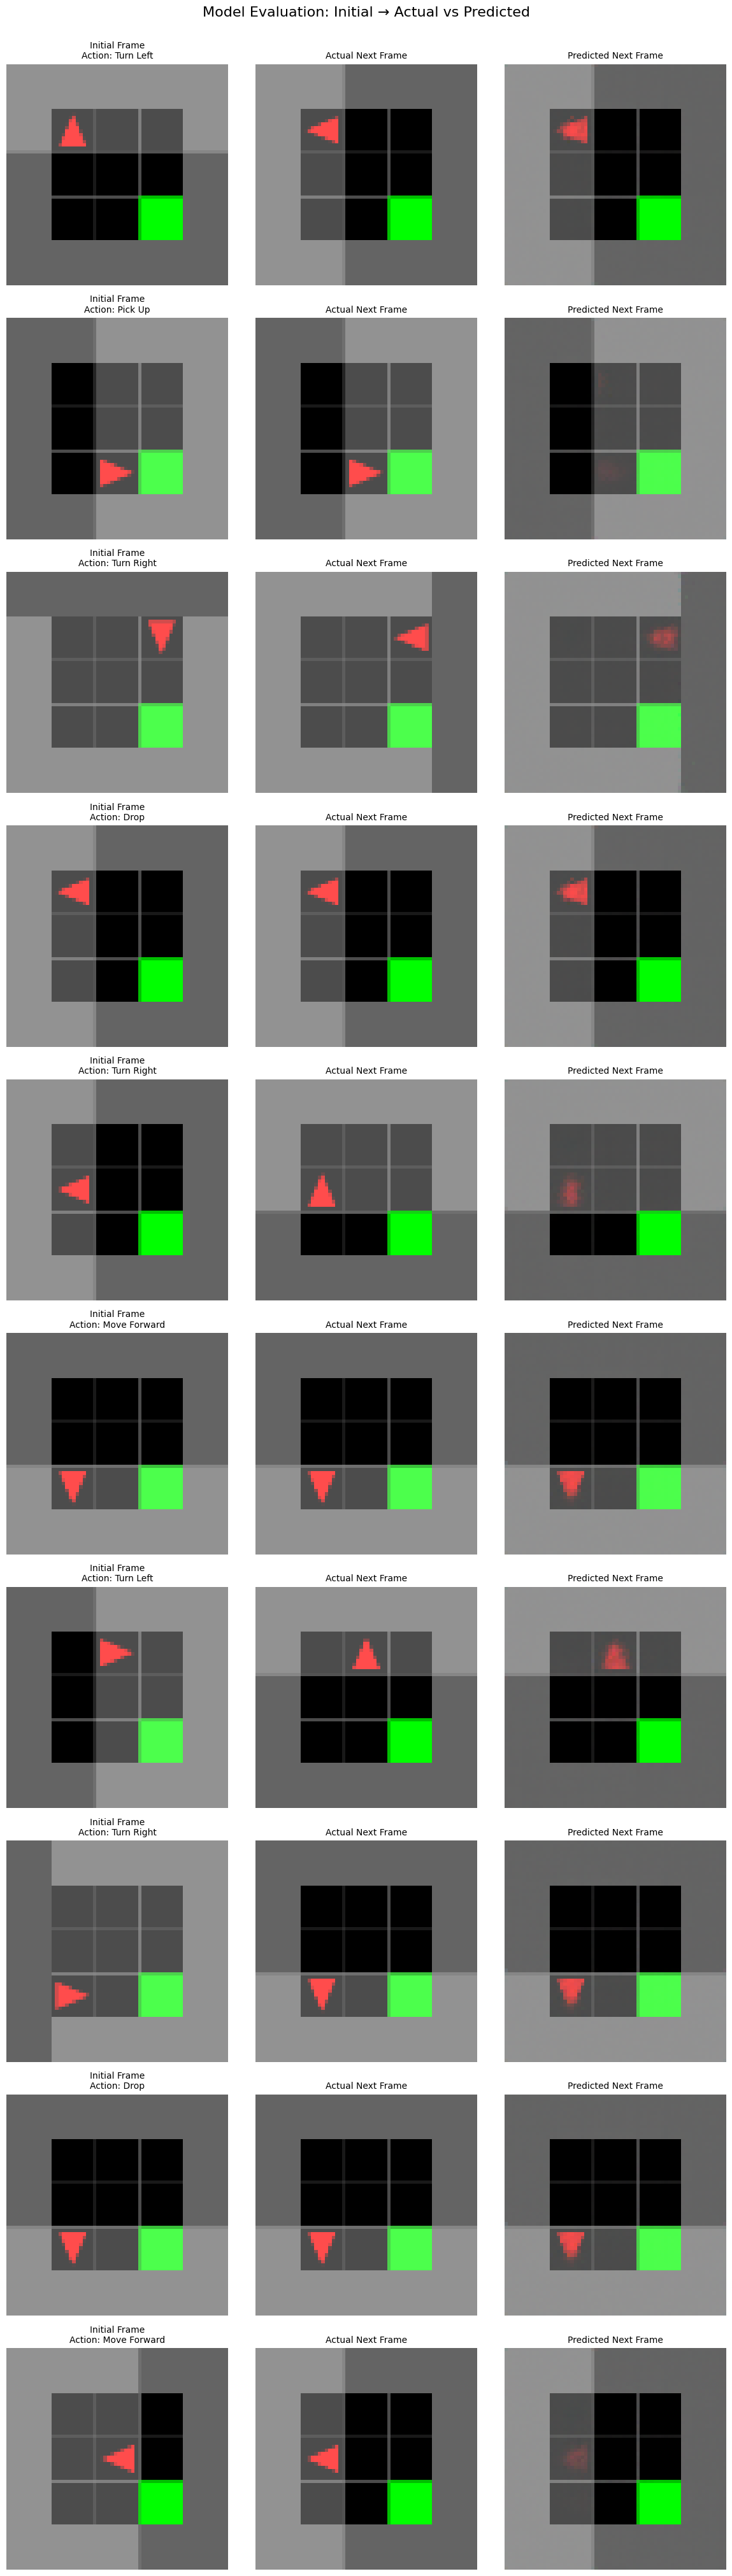


=== Evaluation Metrics ===
Mean Squared Error (MSE): 0.000447
Mean Absolute Error (MAE): 0.001996
Peak Signal-to-Noise Ratio (PSNR): 33.50 dB


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model_with_grid(model, dataloader, device, num_samples=10):

    model.eval()
    
    actual_images = []
    predicted_images = []
    initial_frames = []
    actions_taken = []
    
    with torch.inference_mode():
        sample_count = 0
        for initial_frame, action, next_frame in dataloader:
            if sample_count >= num_samples:
                break
            
            predicted_frame = model(initial_frame, action)
            
            batch_size = min(initial_frame.shape[0], num_samples - sample_count)
            
            for i in range(batch_size):
             
                actual_img = next_frame[i].detach().cpu().permute(1, 2, 0).numpy()
                pred_img = predicted_frame[i].detach().cpu().permute(1, 2, 0).numpy()
                initial_img = initial_frame[i].detach().cpu().permute(1, 2, 0).numpy()
                
                
                actual_img = np.clip(actual_img, 0, 1)
                pred_img = np.clip(pred_img, 0, 1)
                initial_img = np.clip(initial_img, 0, 1)
                
                actual_images.append(actual_img)
                predicted_images.append(pred_img)
                initial_frames.append(initial_img)
                actions_taken.append(action[i].item())
                
                sample_count += 1
                if sample_count >= num_samples:
                    break
    
  
    fig, axes = plt.subplots(num_samples, 3, figsize=(12, 4*num_samples))
    
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    action_names = ['Turn Left', 'Turn Right', 'Move Forward', 'Pick Up', 'Drop', 'Toggle', 'Done']
    
    for i in range(num_samples):
     
        axes[i, 0].imshow(initial_frames[i])
        axes[i, 0].set_title(f'Initial Frame\nAction: {action_names[actions_taken[i]]}', fontsize=10)
        axes[i, 0].axis('off')
        
   
        axes[i, 1].imshow(actual_images[i])
        axes[i, 1].set_title('Actual Next Frame', fontsize=10)
        axes[i, 1].axis('off')
        
      
        axes[i, 2].imshow(predicted_images[i])
        axes[i, 2].set_title('Predicted Next Frame', fontsize=10)
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.suptitle('Model Evaluation: Initial → Actual vs Predicted', fontsize=16, y=1.01)
    plt.savefig('model_evaluation_grid.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Calculate metrics
    actual_array = np.array(actual_images)
    pred_array = np.array(predicted_images)
    
    mse = np.mean((actual_array - pred_array) ** 2)
    mae = np.mean(np.abs(actual_array - pred_array))
    psnr = 20 * np.log10(1.0 / np.sqrt(mse)) if mse > 0 else float('inf')
    
    print(f"\n=== Evaluation Metrics ===")
    print(f"Mean Squared Error (MSE): {mse:.6f}")
    print(f"Mean Absolute Error (MAE): {mae:.6f}")
    print(f"Peak Signal-to-Noise Ratio (PSNR): {psnr:.2f} dB")

# Run the evaluation
evaluate_model_with_grid(test_model, testDataloader, device, num_samples=10)